In [2]:
### Capstone 2 - Part 3 :  E-Commerce Customer Segmentation

# Clustering Algorithms for Customer Segmentation :

'''
Applying unsupervised learning algorithms (e.g., K-means clustering, Hierarchical clustering) to segment customers
Determining the optimal number of clusters using techniques such as the elbow method or silhouette score
Interpreting customer segments based on cluster characteristics and feature importance
Visualize the clusters using PCA
'''

'''
Capstone 2 - Part 1: E-Commerce Customer Segmentation
Data Retrieval and Exploration
Importing necessary libraries:
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  


#Loading the dataset:

df = pd.read_csv("ecommercedata.csv")

#Exploring the dataset:

print(df.head())
print(df.info())
print(df.describe())
print(df.columns)

#Data Preprocessing and Handling missing values:

print(df.isnull().sum())

# Check for duplicates
print(df.duplicated().sum())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo   

In [3]:
### Feature Engineering and Exploratory Data Analysis (EDA)

# Calculate recency, frequency, and monetary value (RFM)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceDate_Day'] = df['InvoiceDate'].dt.day
df['InvoiceDate_Month'] = df['InvoiceDate'].dt.month
df['InvoiceDate_Year'] = df['InvoiceDate'].dt.year


# Handling datetime data for scaling
df['InvoiceYear'] = pd.to_datetime(df['InvoiceDate']).dt.year


'''
# Selecting numerical columns for scaling and correlation
#numerical_cols = ['Recency', 'Frequency', 'MonetaryValue', 'InvoiceYear']

# Standardize only the existing numerical features
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
'''


# Define the numerical columns
numerical_cols = ['Recency', 'Frequency', 'MonetaryValue']

# Verify if all specified columns exist in the DataFrame
missing_cols = [col for col in numerical_cols if col not in df.columns]
if missing_cols:
    print(f"Warning: Some columns in 'numerical_cols' are missing: {missing_cols}")
else:
    # Check data types
    if not all(dt in [np.float32, np.float64, np.int32, np.int64] for dt in df[numerical_cols].dtypes):
        print("Warning: Data types in 'numerical_cols' might not be compatible with StandardScaler. Consider converting them to numerical types.")
    
    # Standardize only the existing numerical features
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# Ensure 'InvoiceDate' is in datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Set a snapshot date for Recency calculation
snapshot_date = df['InvoiceDate'].max() + pd.DateOffset(days=1)

# Recency: Days since the last purchase
df['Recency'] = (snapshot_date - df['InvoiceDate']).dt.days

# Frequency: Number of purchases per customer
frequency = df.groupby('CustomerID').size().reset_index(name='Frequency')

# Monetary: Total amount spent per customer
df['Amount'] = df['Quantity'] * df['UnitPrice']  # Calculate total amount for each transaction
monetary = df.groupby('CustomerID')['Amount'].sum().reset_index(name='MonetaryValue')

# Merge Frequency and Monetary values with the Recency DataFrame
rfm_df = df[['CustomerID', 'Recency']].drop_duplicates()
rfm_df = rfm_df.merge(frequency, on='CustomerID', how='left')
rfm_df = rfm_df.merge(monetary, on='CustomerID', how='left')

# Define numerical columns
numerical_cols = ['Recency', 'Frequency', 'MonetaryValue']

# Check if all numerical columns are present
missing_cols = [col for col in numerical_cols if col not in rfm_df.columns]
if missing_cols:
    print(f"Warning: Some columns in 'numerical_cols' are missing: {missing_cols}")
else:
    # Handle missing values (optional)
    rfm_df[numerical_cols] = rfm_df[numerical_cols].fillna(0)  # Example: fill missing values with 0

    # Standardize the RFM values
    scaler = StandardScaler()
    rfm_df[numerical_cols] = scaler.fit_transform(rfm_df[numerical_cols])

print(rfm_df.head())

   CustomerID   Recency  Frequency  MonetaryValue
0     17850.0  1.871835  -0.040159      -0.123038
1     13047.0  1.871835  -0.165428      -0.214430
2     12583.0  1.871835  -0.106034      -0.044502
3     13748.0  1.871835  -0.346852      -0.302567
4     15100.0  1.871835  -0.370610      -0.315520


In [5]:
# Convert 'Quantity' to numeric (if it is not already)
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')

# Calculate RFM metrics
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': 'max',          # Recency: Last purchase date
    'InvoiceNo': 'nunique',        # Frequency: Number of unique invoices
    'Quantity': 'sum'              # MonetaryValue: Total quantity purchased
})

# Rename columns for clarity
rfm.columns = ['LastPurchaseDate', 'Frequency', 'MonetaryValue']

# Calculate Recency
snapshot_date = df['InvoiceDate'].max() + pd.DateOffset(days=1)
rfm['Recency'] = (snapshot_date - rfm['LastPurchaseDate']).dt.days

# Drop the 'LastPurchaseDate' column as it is no longer needed
rfm = rfm.drop(columns=['LastPurchaseDate'])

# Check RFM DataFrame
print(rfm.head())

# Merge RFM metrics back to the original DataFrame
df = pd.merge(df, rfm, on='CustomerID', how='left')

# Check the result
print(df.head())

# Calculate the correlation matrix for numeric columns
correlation_matrix = df.select_dtypes(include=[np.number]).corr()

# Display the correlation matrix
print(correlation_matrix)

            Frequency  MonetaryValue  Recency
CustomerID                                   
12346.0             2              0      326
12347.0             7           2458        2
12348.0             4           2341       75
12349.0             1            631       19
12350.0             1            197      310
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  InvoiceDate_Day  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom                1   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom                1   
2 

Available columns: Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'InvoiceDate_Day',
       'InvoiceDate_Month', 'InvoiceDate_Year', 'InvoiceYear', 'Recency_x',
       'Amount', 'Frequency', 'MonetaryValue', 'Recency_y'],
      dtype='object')


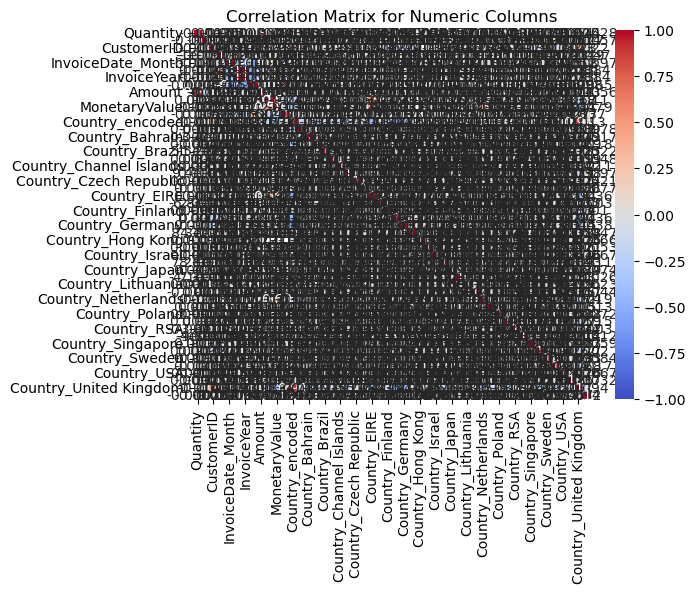

In [6]:
# Check which columns are available
print("Available columns:", df.columns)

# Calculate correlation matrix for specified numerical columns
numerical_cols = ['Recency', 'Frequency', 'MonetaryValue']

# Check for missing columns
missing_cols = [col for col in numerical_cols if col not in df.columns]
if missing_cols:
    print(f"Warning: Missing columns for correlation matrix: {missing_cols}")
else:
    # Calculate the correlation matrix
    correlation_matrix = df[numerical_cols].corr()

    # Plot the heatmap
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix')
    plt.show()
    
# Select numeric columns
numeric_df = df.select_dtypes(include=[np.number])

from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Encode categorical columns (example for a column named 'Country')
if 'Country' in df.columns:
    df['Country_encoded'] = label_encoder.fit_transform(df['Country'])

# One-hot encode categorical columns (example for a column named 'Country')
df_encoded = pd.get_dummies(df, columns=['Country'], drop_first=True)

# Select numeric columns from the updated DataFrame
numeric_df = df_encoded.select_dtypes(include=[np.number])

# Calculate correlation matrix
correlation_matrix_all = numeric_df.corr()

# Plot the heatmap
sns.heatmap(correlation_matrix_all, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Numeric Columns')
plt.show()


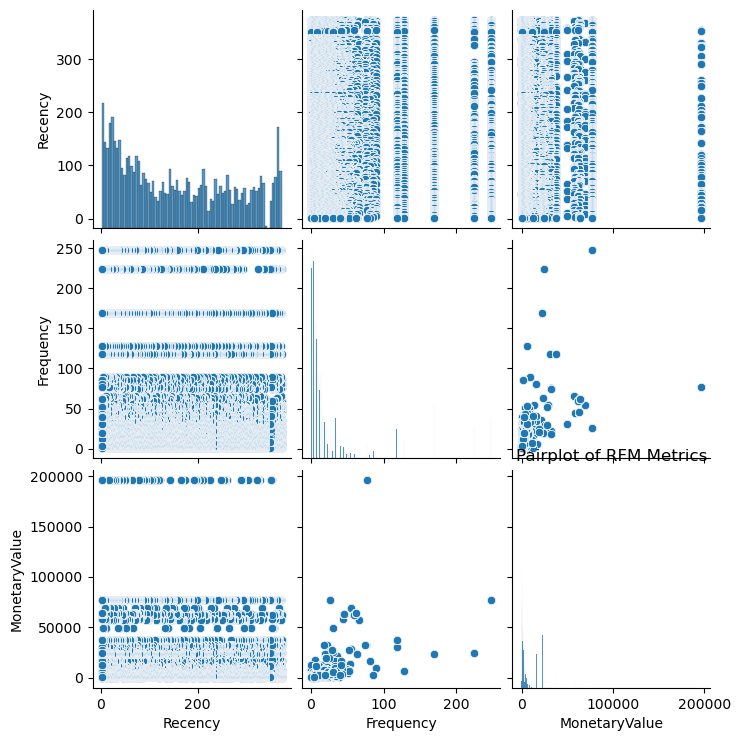

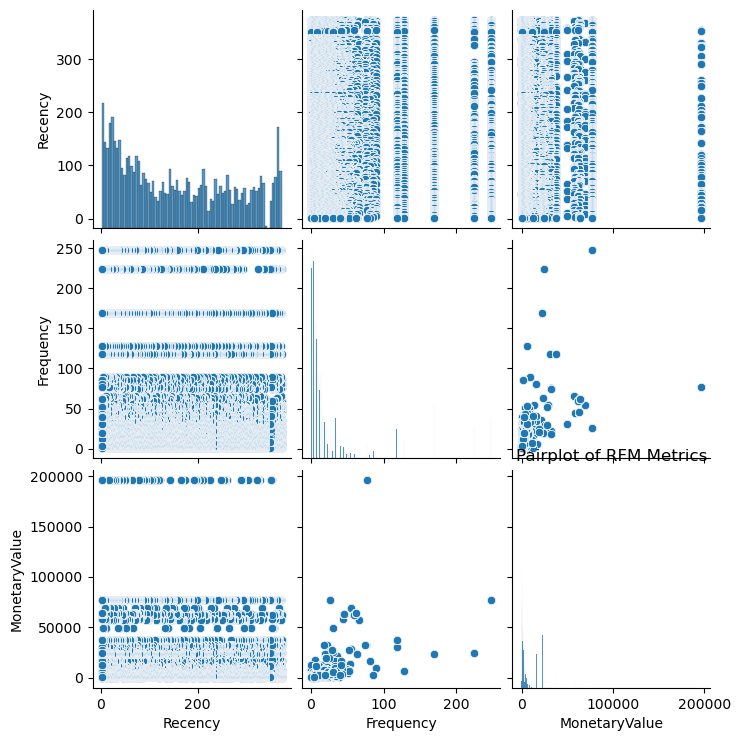

In [8]:
# Plot only the available columns
# Define the columns you want to include
required_columns = ['Recency', 'Frequency', 'MonetaryValue']

# Check which columns are available in the DataFrame
available_columns = [col for col in required_columns if col in df.columns]
missing_columns = [col for col in required_columns if col not in df.columns]

# Plot only the available columns
if available_columns:
    sns.pairplot(df[available_columns])
    plt.title('Pairplot of RFM Metrics')
    plt.show()
else:
    print("No valid columns available for pairplot.")
if available_columns:
    sns.pairplot(df[available_columns])
    plt.title('Pairplot of RFM Metrics')
    plt.show()
else:
    print("No valid columns available for pairplot.")


In [ ]:
### Data Preprocessing for Clustering and Normaling numerical features:
# Optimize data types
df['Quantity'] = pd.to_numeric(df['Quantity'], downcast='integer')
df['UnitPrice'] = pd.to_numeric(df['UnitPrice'], downcast='float')
df['Amount'] = pd.to_numeric(df['Amount'], downcast='float')
df['CustomerID'] = df['CustomerID'].astype('category')
df['InvoiceNo'] = df['InvoiceNo'].astype('category')

# Ensure 'InvoiceDate' is in datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate Amount
df['Amount'] = df['Quantity'] * df['UnitPrice']

# Calculate Recency
snapshot_date = df['InvoiceDate'].max() + pd.DateOffset(days=1)
df['Recency'] = (snapshot_date - df['InvoiceDate']).dt.days

# Calculate Frequency and MonetaryValue
frequency = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index(name='Frequency')
monetary = df.groupby('CustomerID')['Amount'].sum().reset_index(name='MonetaryValue')

# Calculate Recency for each customer
recency = df.groupby('CustomerID')['Recency'].max().reset_index(name='Recency')

# Merge RFM metrics
rfm = recency.merge(frequency, on='CustomerID')
rfm = rfm.merge(monetary, on='CustomerID')

# Rename columns to avoid conflicts
rfm.rename(columns={'Recency': 'RFM_Recency', 'Frequency': 'RFM_Frequency', 'MonetaryValue': 'RFM_MonetaryValue'}, inplace=True)

# Merge RFM metrics back into the original DataFrame
df = pd.merge(df, rfm, on='CustomerID', how='left')

# Optional: Drop unnecessary columns to save memory
df.drop(columns=['Amount'], inplace=True, errors='ignore')  # Drop if no longer needed

chunk_size = 1000000  # Adjust based on available memory
chunks = pd.read_csv("F:\Files\Karthik's Files\Python Files\ecommercedata.csv", chunksize=chunk_size)

# Process each chunk
for chunk in chunks:
    chunk['InvoiceDate'] = pd.to_datetime(chunk['InvoiceDate'])
    chunk['Amount'] = chunk['Quantity'] * chunk['UnitPrice']
    chunk['Recency'] = (snapshot_date - chunk['InvoiceDate']).dt.days
    
    frequency = chunk.groupby('CustomerID')['InvoiceNo'].nunique().reset_index(name='Frequency')
    monetary = chunk.groupby('CustomerID')['Amount'].sum().reset_index(name='MonetaryValue')
    recency = chunk.groupby('CustomerID')['Recency'].max().reset_index(name='Recency')
    
    rfm = recency.merge(frequency, on='CustomerID')
    rfm = rfm.merge(monetary, on='CustomerID')

    
    # Save or process RFM data as needed

C:\Users\kumar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\kumar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\kumar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\kumar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

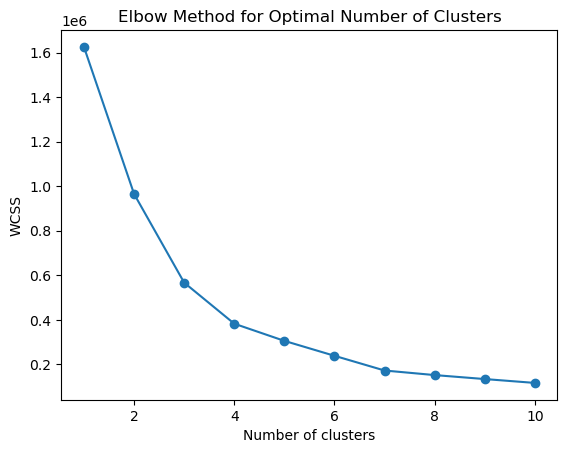

In [10]:
#Customer Segmentation using K-Means Clustering and Determining the optimal number of clusters:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Impute missing values with the mean of each column
df[['Recency', 'Frequency', 'MonetaryValue']] = df[['Recency', 'Frequency', 'MonetaryValue']].fillna(df[['Recency', 'Frequency', 'MonetaryValue']].mean())

# Standardize the features
scaler = StandardScaler()
df[['Recency', 'Frequency', 'MonetaryValue']] = scaler.fit_transform(df[['Recency', 'Frequency', 'MonetaryValue']])

# Initialize the list to hold WCSS values
wcss = []

# Calculate WCSS for different numbers of clusters
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df[['Recency', 'Frequency', 'MonetaryValue']])
    wcss.append(kmeans.inertia_)

# Plot the results
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

C:\Users\kumar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Axes: xlabel='Recency', ylabel='Frequency'>

C:\Users\kumar\anaconda3\Lib\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\kumar\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


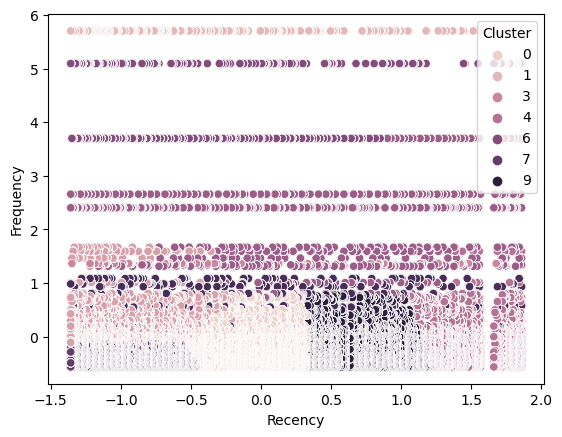

In [11]:
### Creating K-Means clusters:

kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
df['Cluster'] = kmeans.fit_predict(df[['Recency', 'Frequency', 'MonetaryValue']])


### Cluster Analysis and Evaluation and Analyzing cluster characteristics:

df.groupby('Cluster').agg({'Recency': 'mean', 'Frequency': 'mean', 'MonetaryValue': 'mean'})


# Visualizing clusters:

sns.scatterplot(x='Recency', y='Frequency', hue='Cluster', data=df)
### Recommendation System and Identifying popular products within each cluster:


In [12]:
### Recommend products to customers in their respective clusters:
from collections import Counter

def recommend_products(cluster, customer_history, df):
    # Filter the DataFrame to only include customers in the same cluster
    cluster_data = df[df['Cluster'] == cluster]
    
    # Get all products bought by customers in the same cluster
    cluster_products = cluster_data['Description'].tolist()
    
    # Count the frequency of each product
    product_counts = Counter(cluster_products)
    
    # Remove products that the customer has already bought
    for product in customer_history:
        if product in product_counts:
            del product_counts[product]
    
    # Get the most common products
    recommended_products = [product for product, count in product_counts.most_common(10)]
    
    return recommended_products

# Example usage
customer_id = df['CustomerID'][0]
cluster = df[df['CustomerID'] == customer_id]['Cluster'].values[0]
customer_history = df[df['CustomerID'] == customer_id]['Description'].tolist()

# Get recommendations
recommendations = recommend_products(cluster, customer_history, df)
print(f"Recommended products for customer {customer_id}: {recommendations}")

Recommended products for customer 17850.0: ['REGENCY CAKESTAND 3 TIER', 'HEART OF WICKER SMALL', 'JUMBO BAG RED RETROSPOT', 'SET OF 3 CAKE TINS PANTRY DESIGN ', 'JAM MAKING SET PRINTED', nan, 'NATURAL SLATE HEART CHALKBOARD ', 'HEART OF WICKER LARGE', 'JAM MAKING SET WITH JARS', 'SMALL POPCORN HOLDER']


C:\Users\srini\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score (KMeans): 0.5421035976652298
                 Recency  Frequency  MonetaryValue
KMeans_Cluster                                    
0              -0.765287  -0.227063      -0.186063
1              -0.100701   3.417406       2.945551
2               1.022938  -0.180503      -0.176481


<Axes: xlabel='Recency', ylabel='Frequency'>

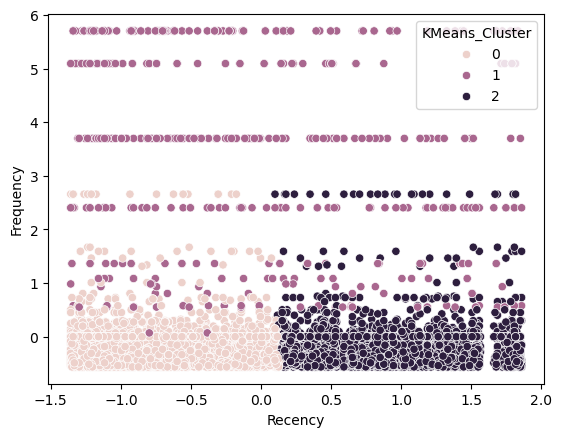

In [56]:
### Capstone 2 - Part 3: Clustering Algorithms for Customer Segmentation

### Cluster Analysis and Evaluation

# Randomly sample a subset of the data
sample_size = 10000  # Adjust based on memory capacity
df_sampled = df.sample(n=sample_size, random_state=42)

# Perform K-Means clustering on the sampled data
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
df_sampled['KMeans_Cluster'] = kmeans.fit_predict(df_sampled[['Recency', 'Frequency', 'MonetaryValue']])

# Calculate the silhouette score on the sampled data
silhouette_score_kmeans = silhouette_score(df_sampled[['Recency', 'Frequency', 'MonetaryValue']], df_sampled['KMeans_Cluster'])

print("Silhouette Score (KMeans):", silhouette_score_kmeans)

# Analyze cluster characteristics (mean values of RFM metrics)
print(df_sampled.groupby('KMeans_Cluster').agg({'Recency': 'mean', 'Frequency': 'mean', 'MonetaryValue': 'mean'}))

# Visualize clusters using RFM features
sns.scatterplot(x='Recency', y='Frequency', hue='KMeans_Cluster', data=df_sampled)

In [50]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Randomly sample a subset of the data
sample_size = 10000  # Adjust size based on memory capacity
df_sampled = df.sample(n=sample_size, random_state=42)

# Perform DBSCAN on the sampled data
dbscan = DBSCAN(eps=0.5, min_samples=5)
df_sampled['DBSCAN_Cluster'] = dbscan.fit_predict(df_sampled[['Recency', 'Frequency', 'MonetaryValue']])

# Calculate the silhouette score on the sampled data
silhouette_score_dbscan = silhouette_score(df_sampled[['Recency', 'Frequency', 'MonetaryValue']], df_sampled['DBSCAN_Cluster'])

print("Silhouette Score (DBSCAN):", silhouette_score_dbscan)


Silhouette Score (DBSCAN): 0.30118581019685525


In [44]:
### Hierarchical Clustering

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Randomly sample a subset of the data
sample_size = 10000  # Adjust this number based on your memory capacity
df_sampled = df.sample(n=sample_size, random_state=42)

# Perform hierarchical clustering on the sampled data
hierarchical_clustering = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
df_sampled['Hierarchical_Cluster'] = hierarchical_clustering.fit_predict(df_sampled[['Recency', 'Frequency', 'MonetaryValue']])

# Calculate the silhouette score for hierarchical clustering on the sampled data
silhouette_score_hierarchical = silhouette_score(df_sampled[['Recency', 'Frequency', 'MonetaryValue']], df_sampled['Hierarchical_Cluster'])

print("Silhouette Score (Hierarchical):", silhouette_score_hierarchical)


C:\Users\srini\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Silhouette Score (Hierarchical): 0.5080993694972701


C:\Users\srini\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


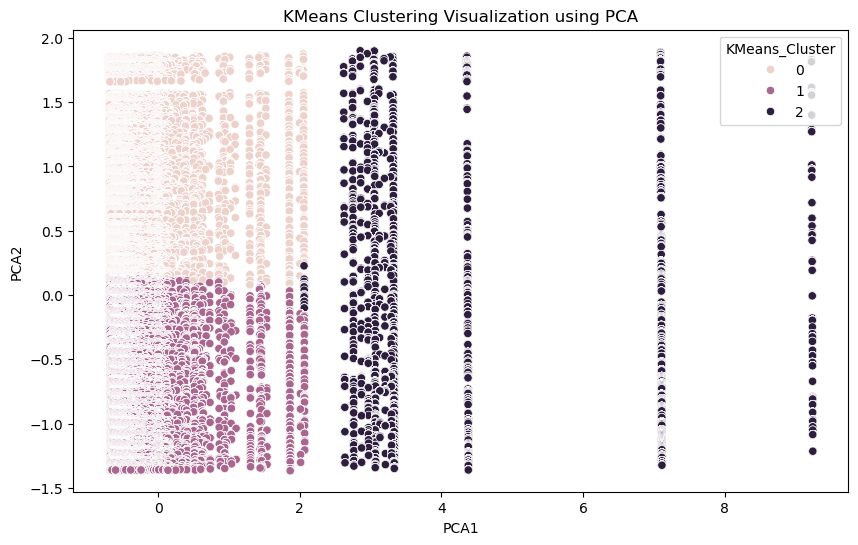

In [67]:
# PCA for visualization

from sklearn.decomposition import PCA

# Perform PCA to reduce the data to 2 components for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df[['Recency', 'Frequency', 'MonetaryValue']])

# Add the PCA results to the DataFrame for plotting
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

# Visualize KMeans Clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='KMeans_Cluster', data=df)
plt.title('KMeans Clustering Visualization using PCA')
plt.show()


C:\Users\srini\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


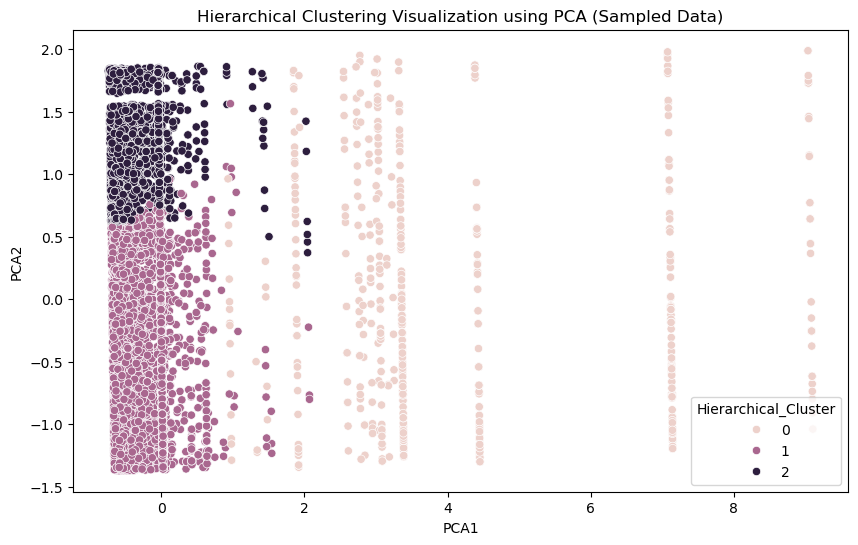

In [75]:
# Visualize Hierarchical Clustering
from sklearn.decomposition import PCA

# Randomly sample a subset of the data
sample_size = 10000  # Adjust based on memory capacity
df_sampled = df.sample(n=sample_size, random_state=42)

# Perform Hierarchical Clustering on the sampled data
hierarchical_clustering = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
df_sampled['Hierarchical_Cluster'] = hierarchical_clustering.fit_predict(df_sampled[['Recency', 'Frequency', 'MonetaryValue']])

# Perform PCA on the sampled data for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_sampled[['Recency', 'Frequency', 'MonetaryValue']])
df_sampled['PCA1'] = pca_result[:, 0]
df_sampled['PCA2'] = pca_result[:, 1]

# Visualize Hierarchical Clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Hierarchical_Cluster', data=df_sampled)
plt.title('Hierarchical Clustering Visualization using PCA (Sampled Data)')
plt.show()

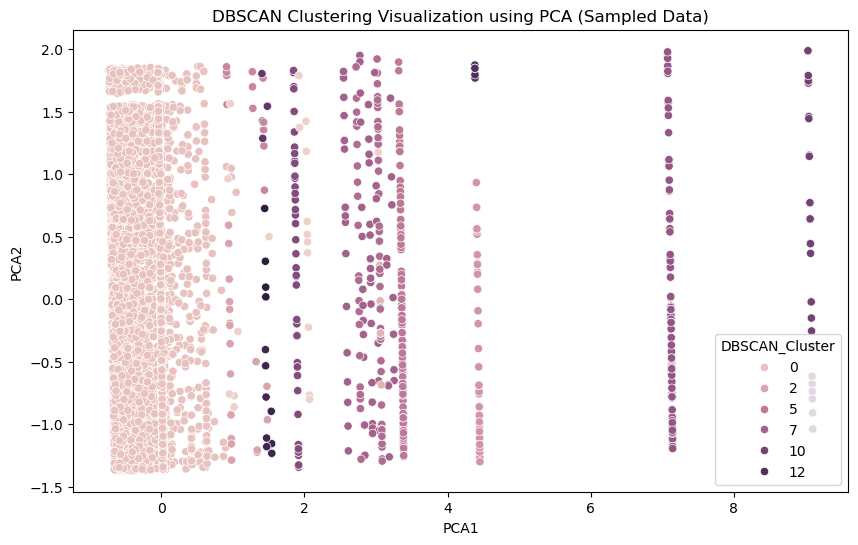

In [77]:
# Visualize DBSCAN Clustering

# Randomly sample a subset of the data
sample_size = 10000  # Adjust based on memory capacity
df_sampled = df.sample(n=sample_size, random_state=42)

# Perform DBSCAN on the sampled data
dbscan = DBSCAN(eps=0.5, min_samples=5)
df_sampled['DBSCAN_Cluster'] = dbscan.fit_predict(df_sampled[['Recency', 'Frequency', 'MonetaryValue']])

# Perform PCA on the sampled data for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_sampled[['Recency', 'Frequency', 'MonetaryValue']])
df_sampled['PCA1'] = pca_result[:, 0]
df_sampled['PCA2'] = pca_result[:, 1]

# Visualize DBSCAN Clustering using PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='DBSCAN_Cluster', data=df_sampled)
plt.title('DBSCAN Clustering Visualization using PCA (Sampled Data)')
plt.show()

Capstone 2 - Part 4 E-Commerce Customer Segmentation : 

TODO: Please make use of Python, Pandas, Numpy, Matplotlib, sklearn and relevant libraries to do the following:

Classification for Segment Prediction (8 pts)
Using any of the supervised learning classification algorithms (e.g., Random Forest, Gradient Boosting, Logistic Regression) predict customer segments:

Split the dataset into training, validation and test sets
Training classification models to predict the segment to which a customer belongs
Validating the classification model's performance and generalization using cross-validation techniques
Evaluating model performance using appropriate metrics (e.g., accuracy, precision, recall, F1-score)
Iteratively refining segmentation and classification strategies based on validation results and stakeholder feedback


Effective Communication (2 pts) : 

Please make use of markdown cells to communicate your thought process, why did you think of performing a step? what was the observation from the visualization(if any)? etc. Make sure the plots(if any) are correctly labelled.
The code should be commented so that it is readable for the reviewer.


Grading and Important Instructions :

Each of the above steps are mandatory and should be completed in good faith
Make sure before submitting that the code is in fully working condition
It is fine to make use of ChatGPT, stackoverflow type resources, just provide the reference links from where you got it
Debugging is an art, if you find yourself stuck with errors, take help of stackoverflow and ChatGPT to resolve the issue and if it's still unresolved, reach out to me for help.

You need to score atleast 7/10 to pass the project, anything less than that will be marked required, needing resubmission.
Feedback will be provided on 3 levels (Awesome, Suggestion, & Required). Required changes are mandatory to be made.
For submission, please upload the project on github and share the link to the file with us through LMS.
Write your code below and do not delete the above instructions. 